# Modelling Stock Volatility with Ornstein-Uhlenbeck process

In [23]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import scipy as sc
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [2]:

# define start and end dates
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=7000)

# download data
stock_prices = yf.download('^GSPC', start=startDate, end=endDate, interval='1d')

print(startDate)
print(stock_prices.head())


/var/folders/j_/mq0l6p1n6vxg5gcc7vg3f7xc0000gn/T/ipykernel_12297/3985177903.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_prices = yf.download('^GSPC', start=startDate, end=endDate, interval='1d')
[*********************100%***********************]  1 of 1 completed

2006-06-18 22:45:33.046196
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2006-06-19  1240.130005  1255.930054  1237.170044  1251.540039  2517200000
2006-06-20  1240.119995  1249.010010  1238.869995  1240.119995  2232950000
2006-06-21  1252.199951  1257.959961  1240.089966  1240.089966  2361230000
2006-06-22  1245.599976  1251.920044  1241.530029  1251.920044  2148180000
2006-06-23  1244.500000  1253.130005  1241.430054  1245.589966  2017270000


### Volatility clustering in financial time series

<i>Paper</i>: Volatility Clustering in Financial Markets:Empirical Facts and Agent–Based Models, Rama Cont. 2005.

The study of statistical properties of financial time series:
 - <b>Excess volatility</b>
 - <b>Heavy Tails</b>
 - <b>Volatilty clustering</b>

As noted by Mandelbrot [1], “large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.”
A quantitative manifestation of this fact is that, while returns themselves are uncorrelated, absolute returns $|r_t|$ or their squares display a positive, significant and slowly decaying autocorrelation function: $corr(|r_t|, |r_t+\tau|) > 0$ for $\tau$ ranging from a few minutes to a several weeks.

[1] B. B. Mandelbrot (1963) The variation of certain speculative prices, Journal of Business, XXXVI (1963), pp. 392–417.

Denote by $S_t$ the price of a financial asset and $X_t = ln S_t$ its logarithm. Given a time scale $\Delta$, the log
return at scale $\Delta$ is defined as:

<center>$r_t = X_{t+\Delta} - X_t = ln(S_t+\Delta S_t)$</center>

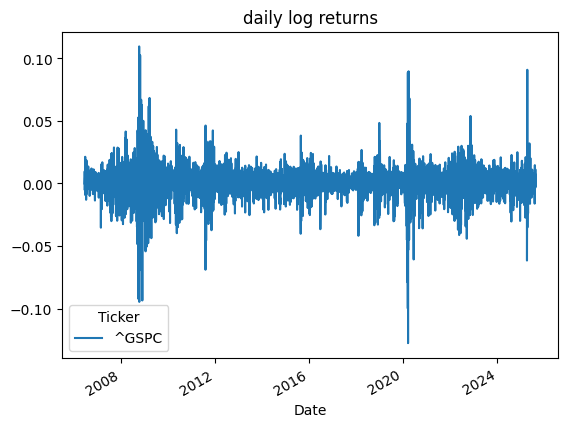

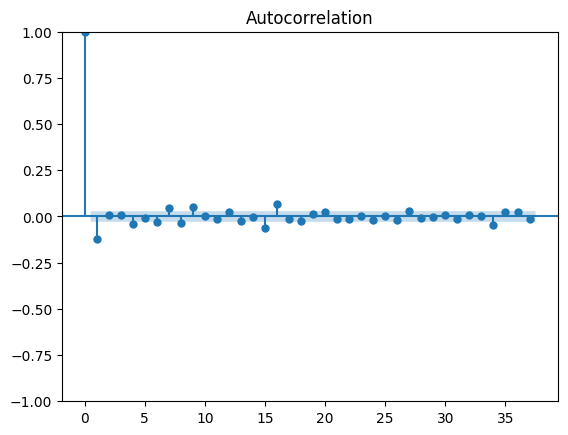

In [3]:
log_returns = np.log(stock_prices.Close/stock_prices.Close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

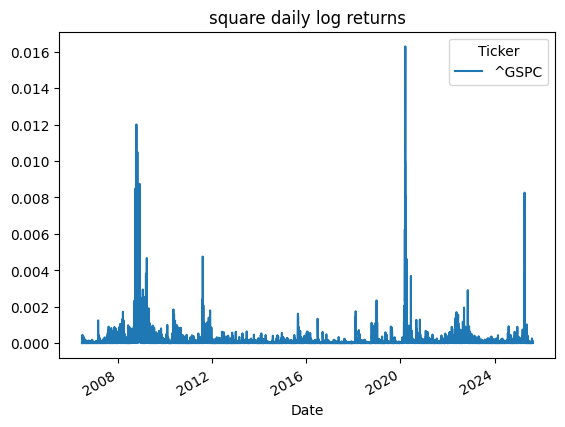

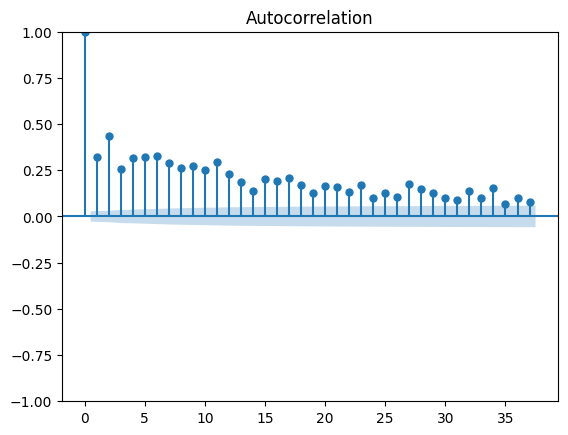

In [4]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

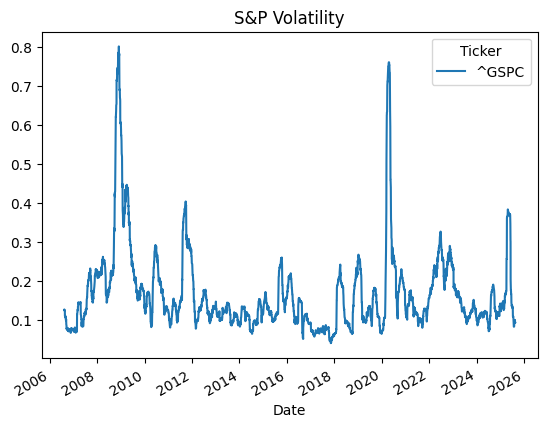

In [5]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('S&P Volatility')
plt.show()

## Ornstein-Uhlenbeck

Ornstein-Uhlenbeck is a stochastic process that is a stationary Gauss-Markov process.

${\displaystyle dX_{t}=-\kappa \,X_{t}\,dt+\sigma \,dW_{t}}$

Sometimes, an additional drift term is sometimes added - this is known as the Vasicek model:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

### Maximum Log-likelihood Estimation (MLE)

Probability Density Function of Normal Distribution is:

 $\Large f_\theta (x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$


If we have random samples $y_i, i = 1,...,N$ from a density $f_\theta (y)$ indexed bu some parameter $\theta$.

Joint Probability Density Function or Likelihood function:
$ f(x_1,...x_n|\theta) =  f(x_1|\theta)...f(x_n|\theta) = \prod^n_{i=1}f(X_i|\theta) = L(\theta)$

The likelihood function is the density function regarded as a function of $\theta$.
$ L(\theta|x) = f(x|\theta), \theta \in \Theta$

The maximum likelihood estimator (MLE):

$\hat{\theta}(x) = arg \underset{\theta}{max} L(\theta|x)$

Log-probability of the observed sample is:

$l(\theta) = \sum^N_{i=1} log f_\theta (y_i)$

The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is
largest.

Essentially we are completing least squares for the additive error model $Y = f_\theta(X) + \epsilon$, with $\epsilon \sim N(0, \sigma^2)$, is equivalent to maximum likelihood using the conditional likelihood:

$f(Y|X, \theta) = N(log f_\theta (X), \sigma^2)$

If we take the likelihood function and derive the partial dericatives with respect the each respective parameter, make equal to zero, then we solve for MLE.

$L(\mu, \sigma^2 | \theta) = (\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_1-\mu)^2}{2 \sigma^2}}) ... \frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_n-\mu)^2}{2 \sigma^2}} = \frac{1}{\sqrt{(2\pi \sigma^2)^n}} e^{-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2}$

Log-likelihood function

$l(\mu, \sigma^2 | \theta) = ln L(\mu, \sigma^2 | \theta) = -\frac{n}{2}(ln2\pi+ln\sigma^2)-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2$

Sometimes this is not differentiable but in the case of the normal distribution we can use Lagrange multiplier method to find maximisation parameters.

- $\frac{\delta}{\delta \mu}ln L(\mu, \sigma^2 | \theta) = 0 = \frac{1}{\sigma^2}\sum^n_{i=1}(x_i-\mu) = \frac{1}{\sigma^2}n(\overline{x} - \mu)$
- $\hat{\mu}(x) = \overline{x}$

This is a local maximum because the second partial derivative with respect to $\mu$ is negative, hence concave function.

- $\frac{\delta}{\delta \sigma^2}ln L(\mu, \sigma^2 | \theta) = 0 = -\frac{n}{2\sigma^2}+\frac{1}{2(\sigma^2)^2}\sum^n_{i=1}(x_i-\mu)^2 =  -\frac{n}{2(\sigma^2)^2}(\sigma^2+\frac{1}{n}\sum^n_{i=1}(x_i-\mu)^2)$
- $\hat{\sigma}^2(x)=\frac{1}{n}\sum^n_{i=1}(x_i-\overline{x})^2$

In [6]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

In [7]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat,2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### performing MLE numerically

If the log likelihood function wasn't continuous or differentiable. Can solve numerically through an optimisation problem where objective function is ...
 
The maximum likelihood estimator (MLE):
$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$ $L(\theta|x)$

$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$  $ln$ $L(\theta|x)$

$L(\theta) = \prod^n_{i=1}f(X_i|\theta)$

$ln f(X∣\theta)=\sum_{i=1}^N ln f(x_i∣\theta)$

In [8]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )

    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [9]:
cons_set = {'type':'ineq', 'fun': sigma_pos}

theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x,), constraints=cons_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1],2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


/var/folders/j_/mq0l6p1n6vxg5gcc7vg3f7xc0000gn/T/ipykernel_12297/2834658178.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### So what's the distribution function of Ornstein-Uhlenbeck process?

Solution use, Ito Calculus to find equation for $d(X_t)$ and then determine Expectation and Variance of $X_t$.

Find dynamics of $X_t$

1. Rearrange

- ${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$
- $dX_t= \kappa \theta dt -\kappa X_t dt+\sigma dW_t$
- $dX_t + \kappa X_t dt = \kappa \theta dt + \sigma dW_t$

We recognise: $d(e^{\kappa t} X_t) =  e^{\kappa t}dX_t + \kappa e^{\kappa t} X_t dt$,

2. so multiply equation through by $e^{\kappa t}$ term. Take integral over time horizon $t \in [0,T]$

- $\int^T_0 d(e^{\kappa t} X_t) = \int^T_0 \kappa \theta e^{\kappa t} dt + \int^T_0 \sigma e^{\kappa t} dW_t$
- $ e^{\kappa T} X_T - X_0 = \kappa \theta \frac{e^{\kappa T}-1}{\kappa} + \sigma \int^T_0 e^{\kappa t} dW_t$
- $ X_T = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t$

Find $E[X_T]$

- $E[X_T] = E[X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t]$
- $E[X_T] = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T})$

Find $Var[X_T] = E[(X_T- E[X_T])^2]$.  Substitute in $X_T$ and $E[X_T]$ derived above.
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\kappa (T-t)} dW_t)^2]$

- Remember Ito Lemma, only term left after cross multiply $dWdW = dt$.
- $Var[X_T] = \sigma^2 \int^T_0 e^{-2\kappa (T-t)} dt$
- $Var[X_T] = \sigma^2 \frac{1-e^{-2\kappa T}}{2 \kappa}$
- $Var[X_T] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa T}) $

Now the stochastic process is normally distributed with $E[X_t]$ and $Var[X_t]$.
- $X_t \sim N(\mu, \sigma)$
- $X_t = \mu + \sigma  Z_t$ where $Z_t \sim N(0, 1)$

- $X_{t+\Delta t} = X_t e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \sqrt{\frac{(1-e^{-2\kappa T})}{2 \kappa}} N(0,1)$

### MLE of Ornstein-Uhlenbeck process
- $X_t \sim N(\mu, \overline{\sigma})$
- $E[X_{t+\delta t}] = X_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa \delta t}) $

 $\Large f_\overline{\theta} (x_{t+\delta t} | x_t, \kappa, \theta, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\mu)^2}{2 \overline{\sigma}^2}}$
 - $\mu(x_t, \kappa, \theta) = x_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $\overline{\sigma}(\kappa, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\kappa \delta t})}{2 \kappa}}$

In [10]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [11]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1/252

    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)

    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )

    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [12]:
vol = np.array(volatility)

In [13]:
cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)

opt

/var/folders/j_/mq0l6p1n6vxg5gcc7vg3f7xc0000gn/T/ipykernel_12297/2647084026.py:14: RuntimeWarning: divide by zero encountered in log
  l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -15462.743303233368
       x: [ 1.737e-01 -8.243e-01  2.157e-01]
     nit: 19
     jac: [ 6.029e+01 -1.208e+01  1.573e+04]
    nfev: 73
    njev: 15

In [14]:
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1][0]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
# print('Last Volatility', round(vol0,3))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.093


### Simulating Ornstein-Uhlenbeck process:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

Continuous-time stochastic process:

$ X_t = X_0 e^{-\kappa t} + \theta (1 - e^{-\kappa t}) + \sigma \int^t_0 e^{-\kappa (t-s)} dW_s$

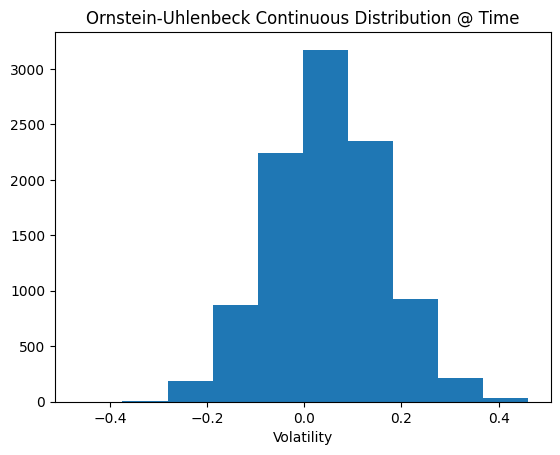

In [15]:
# define parameters
Time = 0.3
M = 10000

Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ Time')
plt.xlabel('Volatility')
plt.show()

### Discretised SDE

Euler-Maryuama discretisation: This is an approximation of variance...

$\Delta x_{t+1} = \kappa(\theta - x_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$

where parameters are assigned as from above optimisation

In [16]:
# Initialise Parameters for discretization
days = 1
years = 2

dt = days/252

M = 1000
N = int(years/dt)

### Recursive function

Execution time 0.0058629512786865234


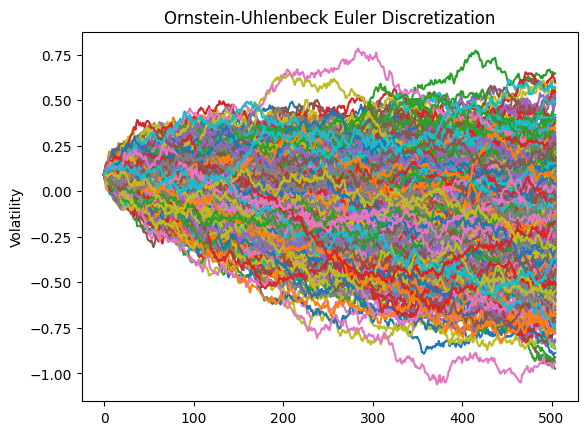

In [25]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

def OU_recursive(t, vol_OU):
    # Return the final state
    if t == N:
        return vol_OU

    # Thread the state through the recursive call
    else:
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t + 1, vol_OU)


start_time = time.time()
vol_OU = OU_recursive(0, vol_OU)
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

### Python Loop

Execution time 0.0016701221466064453


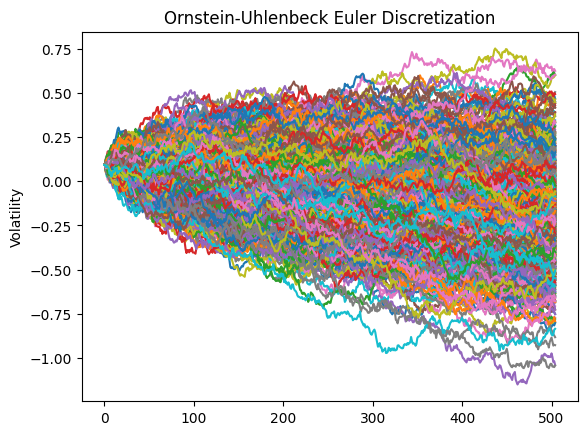

In [18]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)

vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

### Model Selection Criteria: AIC and BIC for CIR Model


In [22]:
import numpy as np
import scipy as sc
from scipy import stats

def calculate_aic_bic_ou(vol_data, kappa, theta, sigma):
    """
    Calculate AIC and BIC for Ornstein-Uhlenbeck model
    
    Parameters:
    vol_data: volatility time series data
    kappa, theta, sigma: OU model parameters
    
    Returns:
    dict with AIC, BIC, log_likelihood, n_params, n_observations
    """
    
    # Calculate log-likelihood
    x_dt = vol_data[1:]  # X_{t+dt}
    x_t = vol_data[:-1]  # X_t
    dt = 1/252  # daily data assuming 252 trading days per year
    
    # OU conditional mean and standard deviation
    mu_ou = x_t * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
    sigma_ou = sigma * np.sqrt((1 - np.exp(-2 * kappa * dt)) / (2 * kappa))
    
    # Calculate log-likelihood
    log_likelihood = np.sum(stats.norm.logpdf(x_dt, loc=mu_ou, scale=sigma_ou))
    
    # Model parameters
    n_params = 3  # kappa, theta, sigma
    n_observations = len(x_dt)
    
    # Calculate AIC and BIC
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_observations) - 2 * log_likelihood
    
    return {
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
        'n_params': n_params,
        'n_observations': n_observations,
        'aic_corrected': aic + (2 * n_params * (n_params + 1)) / (n_observations - n_params - 1)
    }

def compare_models_aic_bic(models_dict):
    """
    Compare multiple models using AIC and BIC
    
    Parameters:
    models_dict: dict of model results from calculate_aic_bic_ou
    
    Returns:
    DataFrame with model comparison
    """
    import pandas as pd
    
    comparison_data = []
    for model_name, metrics in models_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Log_Likelihood': metrics['log_likelihood'],
            'AIC': metrics['aic'],
            'BIC': metrics['bic'],
            'AIC_corrected': metrics['aic_corrected'],
            'N_params': metrics['n_params'],
            'N_obs': metrics['n_observations']
        })
    
    df = pd.DataFrame(comparison_data)
    
    # Add rankings
    df['AIC_rank'] = df['AIC'].rank()
    df['BIC_rank'] = df['BIC'].rank()
    
    return df.sort_values('AIC')

# Example usage with your fitted model:
# Assuming you have your fitted parameters and volatility data

# Calculate metrics for your OU model
ou_metrics = calculate_aic_bic_ou(vol, kappa, theta, sigma)

print("Ornstein-Uhlenbeck Model Evaluation:")
print(f"Log-Likelihood: {ou_metrics['log_likelihood']:.4f}")
print(f"AIC: {ou_metrics['aic']:.4f}")
print(f"BIC: {ou_metrics['bic']:.4f}")
print(f"AIC Corrected: {ou_metrics['aic_corrected']:.4f}")
print(f"Number of parameters: {ou_metrics['n_params']}")
print(f"Number of observations: {ou_metrics['n_observations']}")

# Optional: Calculate AIC and BIC for alternative models for comparison
def calculate_aic_bic_random_walk(vol_data):
    """Random walk model for comparison"""
    returns = np.diff(vol_data)
    mu_rw = np.mean(returns)
    sigma_rw = np.std(returns, ddof=1)
    
    log_likelihood = np.sum(stats.norm.logpdf(returns, loc=mu_rw, scale=sigma_rw))
    n_params = 2  # mu, sigma
    n_observations = len(returns)
    
    aic = 2 * n_params - 2 * log_likelihood
    bic = n_params * np.log(n_observations) - 2 * log_likelihood
    
    return {
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
        'n_params': n_params,
        'n_observations': n_observations,
        'aic_corrected': aic + (2 * n_params * (n_params + 1)) / (n_observations - n_params - 1)
    }

def calculate_aic_bic_ar1(vol_data):
    """AR(1) model for comparison"""
    from statsmodels.tsa.arima.model import ARIMA
    
    model = ARIMA(vol_data, order=(1,0,0))
    fitted_model = model.fit()
    
    return {
        'log_likelihood': fitted_model.llf,
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'n_params': len(fitted_model.params),
        'n_observations': len(vol_data),
        'aic_corrected': fitted_model.aic  # ARIMA already uses corrected AIC
    }

# Compare models
models_comparison = {
    'Ornstein-Uhlenbeck': ou_metrics,
    'Random_Walk': calculate_aic_bic_random_walk(vol),
    'AR(1)': calculate_aic_bic_ar1(vol)
}

comparison_df = compare_models_aic_bic(models_comparison)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Model selection interpretation
best_aic_model = comparison_df.iloc[0]['Model']
best_bic_model = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Model']

print(f"\nBest model by AIC: {best_aic_model}")
print(f"Best model by BIC: {best_bic_model}")

# Calculate evidence ratios (how much better is the best model)
if len(comparison_df) > 1:
    aic_diff = comparison_df.iloc[1]['AIC'] - comparison_df.iloc[0]['AIC']
    evidence_ratio = np.exp(aic_diff/2)
    print(f"Evidence ratio (AIC): {evidence_ratio:.2f}x better than second best model")

Ornstein-Uhlenbeck Model Evaluation:
Log-Likelihood: 15458.1290
AIC: -30910.2579
BIC: -30890.8414
AIC Corrected: -30910.2529
Number of parameters: 3
Number of observations: 4780

Model Comparison:
             Model  Log_Likelihood           AIC           BIC  AIC_corrected  N_params  N_obs  AIC_rank  BIC_rank
             AR(1)    16746.494916 -33486.989833 -33467.572618  -33486.989833         3   4781       1.0       1.0
Ornstein-Uhlenbeck    15458.128973 -30910.257946 -30890.841358  -30910.252921         3   4780       2.0       2.0
       Random_Walk        0.000000      4.000000     16.944810       4.002512         2   4781       3.0       3.0

Best model by AIC: AR(1)
Best model by BIC: AR(1)
Evidence ratio (AIC): infx better than second best model


/Users/aditya.mishra/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aditya.mishra/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/aditya.mishra/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/aditya.mishra/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/aditya.mishra/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/j_/mq0l6p1n6vxg5g